# Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

# Task 1: Importing Libraries and Helper Functions

Please note: If you haven't already, please install the required packages by executing the code cell below.

In [3]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


# Task 2: Importing and Plotting the Data

In [4]:
# downloading the dataset
(x_train,y_train), (x_test,y_test)= tfutils.datasets.mnist.load_data(one_hot=False) 

In [5]:
# Use just the images belongs to class zero (Handwritten zero digit) in both training and testing dataset
x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train) 
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test) 
x = np.concatenate([x_train,x_test],axis=0) # create a combined list

<IPython.core.display.Javascript object>


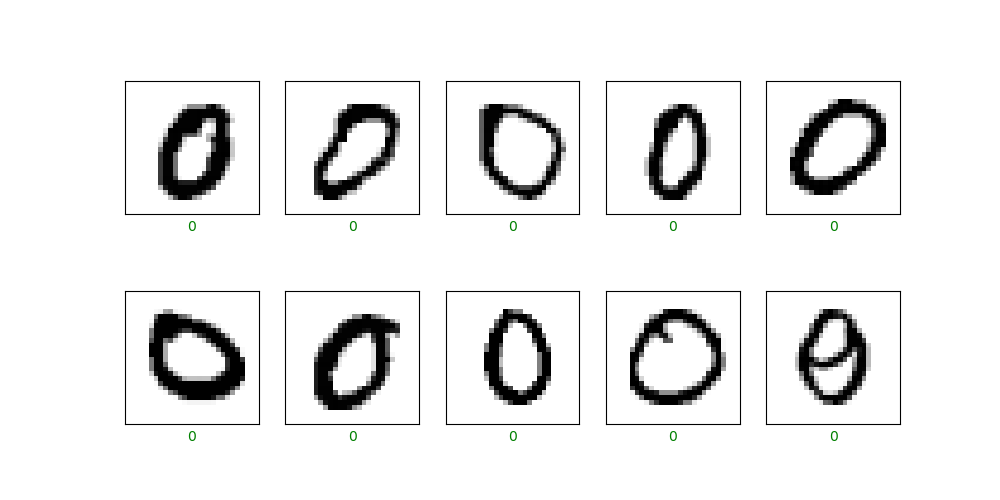

In [18]:
# printing different random examples of the dataset
tfutils.datasets.mnist.plot_ten_random_examples(plt,x,np.zeros((x.shape[0],1))).show()

# Task 3: Discriminator

![Artist and Critic](artist_critic.png)

In [14]:
# Architecture inspired from the original paper 2015 that presented Discriminator
dicriminator=Sequential([ # the dicriminator consists of 3 blocks.
    # First block: convolution block with 64 filters size of 3*3, input shape 28*28*1 
    # images are all black and white. So the channel information is one
    # we use strides to reduce the dimensions instead of using pulling.
    Conv2D(64,3,strides=2, input_shape=(28,28,1)),
    LeakyReLU(), # activation layer
    BatchNormalization(),
    # Second block
    Conv2D(128,5,strides=2),
    LeakyReLU(), # activation layer
    BatchNormalization(),
    #third block
    Conv2D(256,5,strides=2),
    LeakyReLU(), # activation layer
    BatchNormalization(),
    
    Flatten(),
    Dense(1,activation='sigmoid') #Sigmoid activation, Binary classification (fake or real)
    
])
opt=tf.keras.optimizers.Adam(lr=2e-4,beta_1=0.5)
dicriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
dicriminator.summary()
dicriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
dicriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 256)        

# Task 4: Generator

In [6]:
# we can say that the arcthitecture of the generator is 
generator=Sequential([
    #first block
    Dense(256,activation='relu',input_shape=(1,)),
    Reshape((1,1,256)),
    #second block
    Conv2DTranspose (256,5,activation='relu'),
    BatchNormalization(),
    #third block
    Conv2DTranspose(128,5,activation='relu'),
    BatchNormalization(),
    #forth block
    Conv2DTranspose(64,5,strides=2,activation='relu'),
    BatchNormalization(),
    #fifth block    
    Conv2DTranspose(64,5,activation='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(1,4,activation='sigmoid') #filter
])

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)        2

In [7]:
noise=np.random.randn(1,1)
gen_image=generator.predict(noise)[0]

<IPython.core.display.Javascript object>


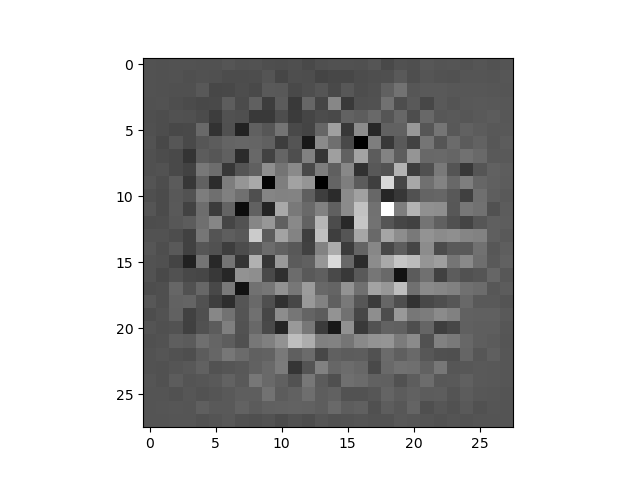

In [9]:
plt.figure()
plt.imshow(np.reshape(gen_image,(28,28)),cmap='binary')

# Task 5: Generative Adversarial Network (GAN)
Having the generator and the discriminator, we can connect the two to create our generative adversarial networks.

In [15]:
input_layer=tf.keras.layers.Input(shape=(1,))
gen_out=generator(input_layer)
disc_out=dicriminator(gen_out)

gen=Model(
input_layer,
disc_out)

dicriminator.trainable=False #  True when we are training discriminator and false otherwise
# while the generator is being trained we do not want to train the discriminator.
# After that we will train the whole network.
gen.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gen.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         2768897   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1027073   
Total params: 3,795,970
Trainable params: 2,767,873
Non-trainable params: 1,028,097
_________________________________________________________________


# Tasks 6 and 7: Training the GAN

In [16]:
epochs=25
batch_size=128
steps_per_epoch=int(2*x.shape[0]/batch_size) # in each step only half of the real examples are used,
# and that is why we are multiplying the number of examples by 2
####
# what are we doing : take true examples from the dataset and take some randomaly generated 
# images from the generator, to create a training batch for the network
# then we will set the training the discriminator to true and train it on that batch
# then we will not train the discriminator but we will train the network
# we want to set the labels: 1 for real images, and 0 to fake images
# then the artist is forsed to keep trying to achieve those labels for this batch  
# then better images will be generated by the artist
print('Steps per epochs= ', steps_per_epoch)

Steps per epochs=  107


<IPython.core.display.Javascript object>


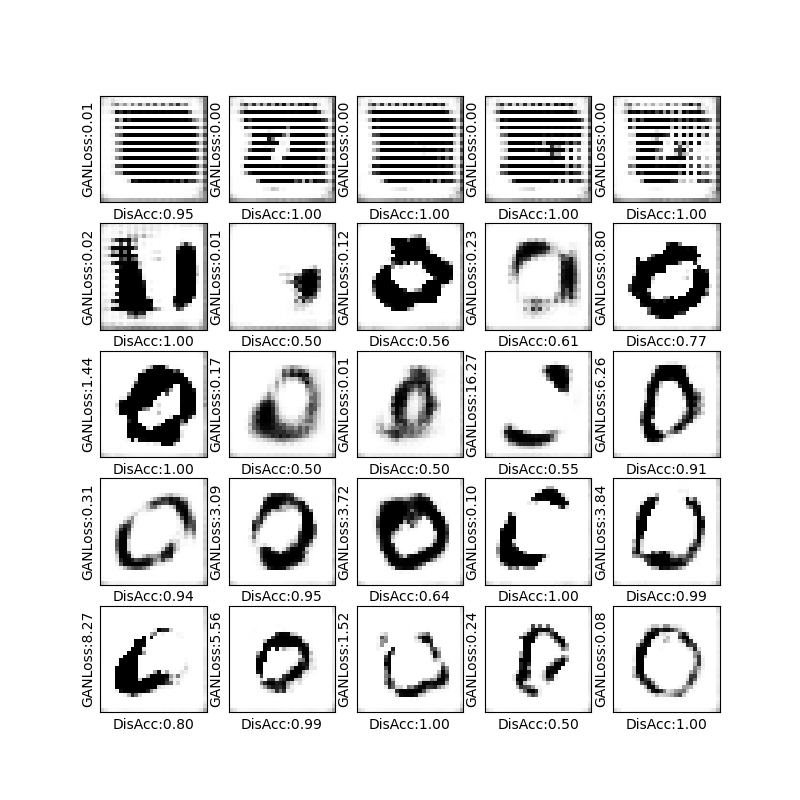

In [21]:
# In this plot we'll see the generator's output after each epoch.
dp=tfutils.plotting.DynamicPlot(plt,5,5,(8,8)) 
for e in range(0, epochs):
    dp.start_of_epoch(e)
    for step in range(0,steps_per_epoch):
        # True examples
        true_examples=x[int(batch_size/2)*step:int(batch_size/2)*(step+1)]
        true_examples=np.reshape(true_examples,(true_examples.shape[0],28,28,1))
        # Generated examples
        noise=np.random.rand(int(batch_size/2),1)
        gen_examples=generator.predict(noise)
        # concatenate the generated examples and the true examples
        x_batch=np.concatenate([gen_examples,true_examples],axis=0)
        # create the labels 
        y_batch=np.array([0]*int(batch_size/2)+[1]*int(batch_size/2)) 
        
        indices=np.random.choice(range(batch_size),batch_size,replace=False)
        
        x_batch=x_batch[indices]
        y_batch=y_batch[indices]
        
        dicriminator.trainable=True # create and train the discriminator.
        dicriminator.train_on_batch(x_batch, y_batch)
        dicriminator.trainable=False # after training it, we set it back to nontrainable
        
        # Training the generator part
        loss, _ =gen.train_on_batch(noise, np.ones((int(batch_size/2),1))) #tuple
        _,acc =dicriminator.evaluate(x_batch,y_batch,verbose=False)
        # acc of dicriminator, if this accuracy is high then the discriminator is doing well
        # but as the model train more and more, this will reflect the generator work
        # generator does well ==> discriminator accuracy get reduced
    noise=np.random.randn(1,1)
    gen_image=generator.predict(noise)[0]
    gen_image=np.reshape(gen_image,(28,28)) # reshaping for plotting
    dp.end_of_epoch(gen_image, 'binary', 'DisAcc:{:.2f}'.format(acc),'GANLoss:{:.2f}'.format(loss))
        
        